# [E-12] Korean Chatbot
## 한국어 챗봇 만들기
### 학습 목표
* 트랜스포머의 인코더 디코더 구조 이해하기
* 내부 단어 토크나이저 사용하기
* 셀프 어텐션 이해하기
* 한국어에도 적용해보기


### 목차
#### 1. 들어가며
  1-1. 트랜스포머(Transformer)
  1-2. 트랜스포머의 인코더와 디코더
  1-3. 어텐션
  1-4. 트랜스포머에서 사용된 어텐션
  1-6. 셀프 어텐션(Self Attention)

#### 2. 프로젝트
  2-1. 준비하기
  2-2. 함수 구현
  2-3. 마스킹
  2-4. 인코더 & 디코더
  2-5. 한국어 챗봇 데이터 가져오기
  2-6. 전처리
  2-7. 모델 정의 및 학습하기
  2-8. 챗봇 테스트하기

#### 3. 회고
  3-1. 정리
  3-2. 이번 프로젝트에서 어려웠던 점
  3-3. 프로젝트를 진행하면서 알아낸 점, 혹은 아직 모호한 점
  3-4. 루브릭 평가 지표를 맞추기 위해 시도한 것들
  3-5. 궁금한 사항
  3-6. 참고사이트



### 루브릭 평가 기준
|평가문항|상세기준|
|:---|:---|
|1. 한국어 전처리를 통해 학습 데이터셋을 구축하였다.|공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행되었다.|
|2. 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다.|구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다.|
|3. 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다.|한국어 입력문장에 그럴듯한 한국어로 답변을 리턴하였다.|   
<br/>

----


## 1. 들어가며
### 1-1. 트랜스포머(Transformer)
* 트랜스포머(Transformer)는 2017년 구글이 발표한 논문인 "Attention is all you need"에서 나온 모델로 기존의 seq2seq의 구조인 인코더-디코더를 따르면서도, 논문의 이름처럼 어텐션(Attention)만으로 구현한 모델

### 1-2. 트랜스포머의 인코더와 디코더
* 기본적으로 인코더와 디코더 구성을 가지고 있음
* 입력 문장을 넣으면 출력 문장을 내뱉음

### 1-3. 어텐션
* 주어진 쿼리에 대해서 모든 키와의 유사도를 각각 구하는 것
* 구해낸 이 유사도를 키와 맵핑되어있는 각각의 값(Value)에 반영해줌
* 유사도가 반영된 '값(Value)'을 모두 더해서 뭉쳐주면 이를 최종 결과인 **어텐션 값(Attention Value)** 


### 1-4. 트랜스포머에서 사용된 어텐션
* 트랜스포머의 어텐션 함수에 사용되는 쿼리(Query), 키(Key), 밸류(Value) 는 기본적으로 '단어 (정보를 함축한) 벡터' 
* **'단어 벡터'** 란 초기 입력으로 사용되었던 임베딩 벡터가 아니고, 트랜스포머의 여러 연산을 거친 후의 단어 벡터

* 인코더 셀프 어텐션 : 인코더의 입력으로 들어간 문장 내 단어들이 서로 유사도를 구한다.
* 디코더 셀프 어텐션 : 단어를 1개씩 생성하는 디코더가 이미 생성된 앞 단어들과의 유사도를 구한다.
* 인코더-디코더 어텐션 : 디코더가 잘! 예측하기 위해서 인코더에 입력된 단어들과 유사도를 구한다.


### 1-6. 셀프 어텐션(Self Attention)
* 유사도를 구하는 대상이 다른 문장의 단어가 아니라 현재 문장 내의 단어들이 서로 유사도를 구하는 경우를 의미
* 인코더-디코더 어텐션은 서로 다른 단어 목록(인코더 내 단어와 디코더 내 단어) 사이에서 유사도를 구하기 때문에 셀프 어텐션이 아님!

* 내적(dot product)을 통해 단어 벡터 간 유사도를 구한 후에, 특정 값을 분모로 나눠주는 방식으로 QQ와 KK의 유사도를 구하였다고 하여 **스케일드 닷 프로덕트 어텐션(Scaled Dot Product Attention)**

---

## 2. 프로젝트
### 2-1. 준비하기

#### 필요한 패키지 임포트

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

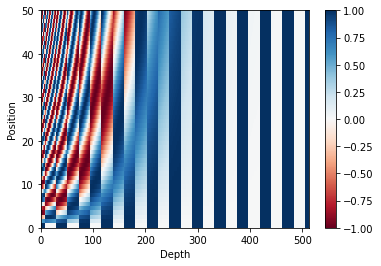

In [3]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### 2-2. 함수 구현
#### 스케일드 닷 프로덕트 어텐션 함수 구현하기

In [4]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output


#### 병렬로 어텐션 수행하기

#### 멀티-헤드 어텐션 구현하기

In [5]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

### 2-3. 마스킹
* 특정 값들을 가려서 실제 연산에 방해가 되지 않도록 하는 기법

#### 패딩 마스킹(Padding Masking)
* 패딩 토큰(Padding token)을 이용한 방법

* **pad_sequences()**
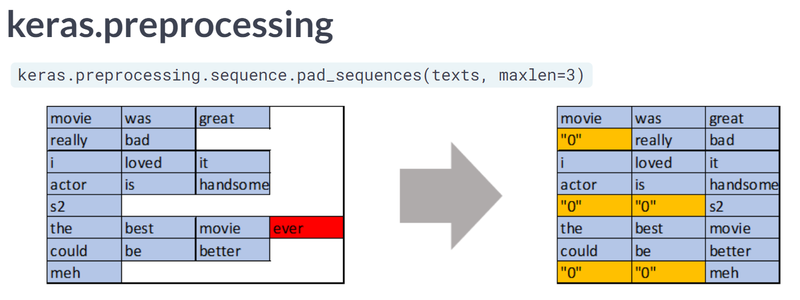



In [6]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [7]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


In [8]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)


In [9]:
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [10]:
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


### 2-4. 인코더 & 디코더

In [11]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
          d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
          epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)


#### 인코더 층을 쌓아 인코더 만들기

In [12]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [13]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
          d_model, num_heads, name="attention_1")(inputs={
              'query': inputs,
              'key': inputs,
              'value': inputs,
              'mask': look_ahead_mask
        })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
          epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
          d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)


#### 디코더 층을 쌓아 디코더 만들기

In [14]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
      outputs = decoder_layer(
          units=units,
          d_model=d_model,
          num_heads=num_heads,
          dropout=dropout,
          name='decoder_layer_{}'.format(i),
      )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

### 2-5. 한국어 챗봇 데이터 가져오기
https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv


### 설명
* 챗봇 트레이닝용 문답 페어 11,876개
* 일상다반사 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링

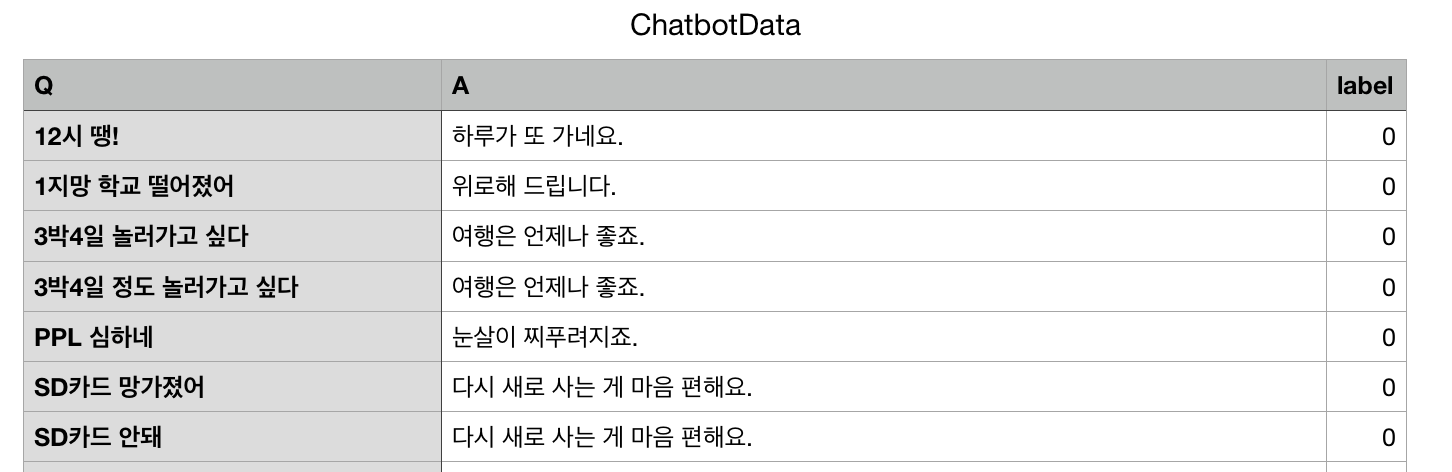

#### 데이터 다운로드
* 파이썬 라이브러리 Pandas로 데이터 프레임 생성 후, csv 파일 읽고 저장하기

In [15]:
import pandas as pd

In [16]:
data = pd.read_csv(os.getenv('HOME') + '/aiffel/Exploration/E_12/transformer_chatbot/data/ChatbotData.csv')
print(data.shape)
data.head()

(11823, 3)


,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


### 2-6. 전처리

#### 정규 표현식(Regular Expression) 을 사용
* 구두점(Punctuation) 제거
* 토크나이징(tokenizing)에 방해되지 않도록 정제하는 것을 목표로 함

In [17]:
# 전처리 함수
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^가-힣a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [18]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
    inputs, outputs = [], []
    for i in range(len(data)):
        # 전처리 함수를 질문에 해당되는 inputs('Q')과 답변에 해당되는 outputs('A')에 적용
        inputs.append(preprocess_sentence(data['Q'].values[i]))
        outputs.append(preprocess_sentence(data['A'].values[i]))
    return inputs, outputs


In [19]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [20]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


#### 병렬 데이터 전처리하기
1. TensorFlow Datasets SubwordTextEncoder를 토크나이저로 사용한다.  단어보다 더 작은 단위인 Subword를 기준으로 토크나이징하고,  각 토큰을 고유한 정수로 인코딩한다.
2. 각 문장을 토큰화하고 각 문장의 시작과 끝을 나타내는 START_TOKEN 및 END_TOKEN을 추가한다.
3. 최대 길이 MAX_LENGTH인 40을 넘는 문장들은 필터링한다.
4. MAX_LENGTH보다 길이가 짧은 문장들은 40에 맞도록 패딩 한다.

#### 1. 단어장(Vocabulary) 만들기

In [21]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.3.0 이상) (클라우드는 2.4 입니다)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)


In [22]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]


In [23]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8133]
END_TOKEN의 번호 : [8134]


In [24]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8135


#### 2. 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)

In [25]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5742, 610, 2483, 4148]
정수 인코딩 후의 21번째 답변 샘플: [2353, 7484, 7, 6249, 97, 1]


In [26]:
# 질문과 답변의 chl길이 살펴보기
question_len = [len(s.split()) for s in questions]
answer_len = [len(s.split()) for s in answers]

print('질문의 최소 길이 : {}'.format(np.min(question_len)))
print('질문의 최대 길이 : {}'.format(np.max(question_len)))
print('질문의 평균 길이 : {}'.format(np.mean(question_len)))
print('답변의 최소 길이 : {}'.format(np.min(answer_len)))
print('답변의 최대 길이 : {}'.format(np.max(answer_len)))
print('답변의 평균 길이 : {}'.format(np.mean(answer_len)))

질문의 최소 길이 : 1
질문의 최대 길이 : 16
질문의 평균 길이 : 3.9391017508246637
답변의 최소 길이 : 1
답변의 최대 길이 : 24
답변의 평균 길이 : 4.716146494121627


In [27]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 16
print(MAX_LENGTH)

16


In [28]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
  
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
  
    # 최대 길이 16으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
          tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
          tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
    return tokenized_inputs, tokenized_outputs

In [29]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8135
필터링 후의 질문 샘플 개수: 11677
필터링 후의 답변 샘플 개수: 11677


#### 3. 교사 강요(Teacher Forcing) 사용하기

* tf.data.Dataset API
  * 훈련 프로세스의 속도가 빨라지도록 입력 파이프라인을 구축하는 API


* 교사 강요(Teacher Forcing)란?


* 자기회귀 모델(auto-regressive model, AR)이란?
  * 이전 자신의 출력이 현재 자신의 상태를 결정하는 모델


In [30]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

### 2-7. 모델 정의 및 학습하기

#### 트랜스포머 함수 정의

In [31]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
          create_padding_mask, output_shape=(1, 1, None),
          name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
          create_look_ahead_mask,
          output_shape=(1, None, None),
          name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
          create_padding_mask, output_shape=(1, 1, None),
          name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
          vocab_size=vocab_size,
          num_layers=num_layers,
          units=units,
          d_model=d_model,
          num_heads=num_heads,
          dropout=dropout,
      )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
          vocab_size=vocab_size,
          num_layers=num_layers,
          units=units,
          d_model=d_model,
          num_heads=num_heads,
          dropout=dropout,
      )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])
  
    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)


#### 1. 모델 생성
* num_layers, d-Model, units는 전부 사용자가 정할 수 있는 하이퍼파라미터 값

In [32]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3136768     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

#### 2. 손실 함수(Loss function)

In [33]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

#### 3. 커스텀 된 학습률(Learning rate)
* 딥러닝 모델학습 시 learning rate는 매우 중요한 하이퍼파라미터

**커스험 학습률 스케쥴링(Custom Learning rate Scheduling)**
* 모델학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급 기법을 널리 사용

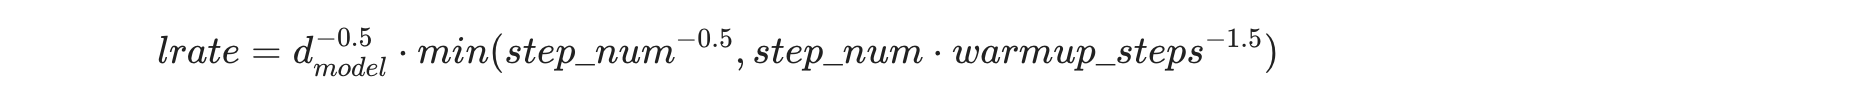

In [34]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


#### 커스텀 학습률 스케줄링 계획 시각화

Text(0.5, 0, 'Train Step')

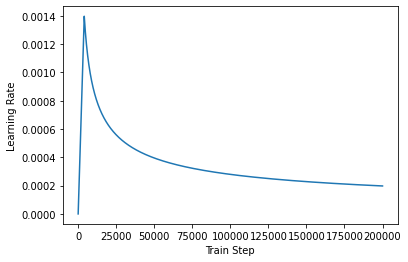

In [35]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

#### 4. 모델 컴파일 
#### 손실 함수와 커스텀 된 학습률(Learning rate)을 사용하여 모델을 컴파일

In [36]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

#### 5. 훈련하기


In [37]:
EPOCHS = 150
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/150
183/183 [==============================] - 12s 34ms/step - loss: 3.7052 - accuracy: 0.0534
Epoch 2/150
183/183 [==============================] - 6s 33ms/step - loss: 3.0120 - accuracy: 0.1281
Epoch 3/150
183/183 [==============================] - 6s 33ms/step - loss: 2.5636 - accuracy: 0.1314
Epoch 4/150
183/183 [==============================] - 6s 33ms/step - loss: 2.3652 - accuracy: 0.1410
Epoch 5/150
183/183 [==============================] - 6s 33ms/step - loss: 2.2176 - accuracy: 0.1487
Epoch 6/150
183/183 [==============================] - 6s 35ms/step - loss: 2.0714 - accuracy: 0.1592
Epoch 7/150
183/183 [==============================] - 6s 34ms/step - loss: 1.9082 - accuracy: 0.1733
Epoch 8/150
183/183 [==============================] - 6s 34ms/step - loss: 1.7241 - accuracy: 0.1924
Epoch 9/150
183/183 [==============================] - 6s 33ms/step - loss: 1.5205 - accuracy: 0.2163
Epoch 10/150
183/183 [==============================] - 6s 34ms/step - loss: 1.30

### 2-8. 챗봇 테스트하기
#### 예측(inference) 단계
1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
2. 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.
3. 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
4. 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
5. 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
6. END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.


In [38]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
          START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

#### 임의의 입력 문장에 대해서 decoder_inference() 함수를 호출하여 챗봇의 대답을 얻는 sentence_generation() 함수

In [39]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence


#### 결과 확인하기

In [40]:
sentence_generation('안녕하세요')

입력 : 안녕하세요
출력 : 안녕하세요 .


'안녕하세요 .'

In [41]:
sentence_generation('배가고프네요')

입력 : 배가고프네요
출력 : 천천히 다시 다가가보세요 .


'천천히 다시 다가가보세요 .'

In [42]:
sentence_generation('배가 고프네요')

입력 : 배가 고프네요
출력 : 안타깝게 생각해요 .


'안타깝게 생각해요 .'

In [43]:
sentence_generation('제 이름은 김수진입니다')

입력 : 제 이름은 김수진입니다
출력 : 시간을 함께 했나봐요 .


'시간을 함께 했나봐요 .'

In [44]:
sentence_generation('당신이 좋아하는 사람은 누구인가요?')

입력 : 당신이 좋아하는 사람은 누구인가요?
출력 : 자신은 원망하지 마세요 .


'자신은 원망하지 마세요 .'

In [45]:
sentence_generation('건강이 나빠지고 있어요')

입력 : 건강이 나빠지고 있어요
출력 : 제자리여도 괜찮아요 .


'제자리여도 괜찮아요 .'

In [46]:
sentence_generation('건조기 살까?')

입력 : 건조기 살까?
출력 : 있으면 편하대요 .


'있으면 편하대요 .'

In [47]:
sentence_generation('세탁기는 어때?')

입력 : 세탁기는 어때?
출력 : 부지런하시네요 .


'부지런하시네요 .'

In [48]:
sentence_generation('배고파')

입력 : 배고파
출력 : 얼른 맛난 음식 드세요 .


'얼른 맛난 음식 드세요 .'

In [49]:
sentence_generation('배고프네요')

입력 : 배고프네요
출력 : 안타깝게 생각해요 .


'안타깝게 생각해요 .'

In [50]:
sentence_generation('영화 볼래?')

입력 : 영화 볼래?
출력 : 최신 영화가 좋을 것 같아요 .


'최신 영화가 좋을 것 같아요 .'

In [51]:
sentence_generation('영화 볼래?')

입력 : 영화 볼래?
출력 : 최신 영화가 좋을 것 같아요 .


'최신 영화가 좋을 것 같아요 .'

In [52]:
sentence_generation('고민이 있어')

입력 : 고민이 있어
출력 : 저는 고민이 없어요 .


'저는 고민이 없어요 .'

In [53]:
sentence_generation('너무 화가나')

입력 : 너무 화가나
출력 : 저랑 상 그게 좋죠 .


'저랑 상 그게 좋죠 .'

In [54]:
sentence_generation('카페갈래?')

입력 : 카페갈래?
출력 : 카페 데이트 좋죠 .


'카페 데이트 좋죠 .'

In [55]:
sentence_generation('게임하고싶다')

입력 : 게임하고싶다
출력 : 그럴 때가 있어요 .


'그럴 때가 있어요 .'

In [56]:
sentence_generation('이별은 슬퍼')

입력 : 이별은 슬퍼
출력 : 후회 , 상상 , 자책 모두 멈출 때가 됐어요 .


'후회 , 상상 , 자책 모두 멈출 때가 됐어요 .'

In [57]:
sentence_generation('살 빼는 건 힘들어')

입력 : 살 빼는 건 힘들어
출력 : 운동을 시작해보세요 .


'운동을 시작해보세요 .'

In [58]:
sentence_generation('삼겹살 먹고싶다')

입력 : 삼겹살 먹고싶다
출력 : 서로의 마음이 중요하겠죠 .


'서로의 마음이 중요하겠죠 .'

In [59]:
sentence_generation('삼겹살 먹고 싶다')

입력 : 삼겹살 먹고 싶다
출력 : 맛나게 드세요 .


'맛나게 드세요 .'

## 3. 회고
### 3-1. 정리

#### 적절히 잘 출력된 문장들
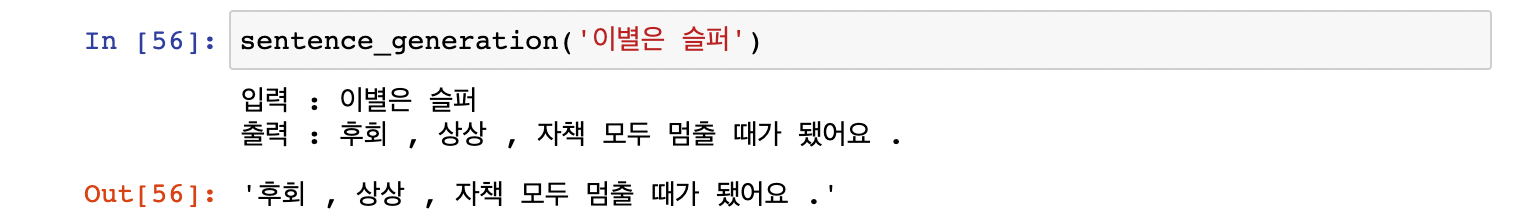
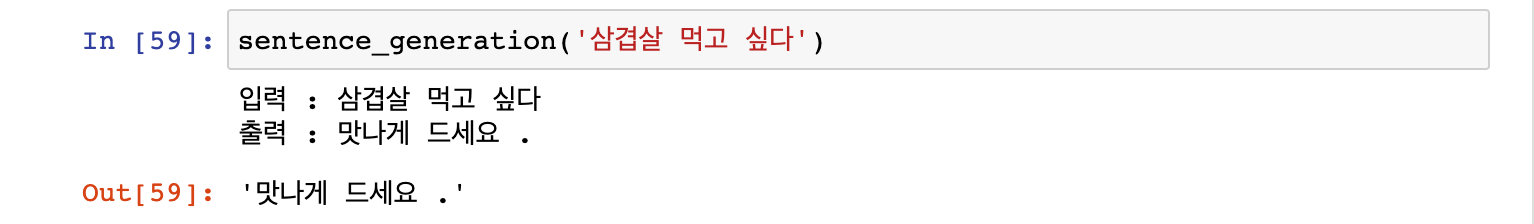

* 위의 두 예시 말고도 입력 데이터와 비슷한 문장을 입력했을 때에는 답변문장이 적절히 잘 출력되었다.

#### 변형되서 출력된 답변 문장
* 제공된 데이터에 있던 내용
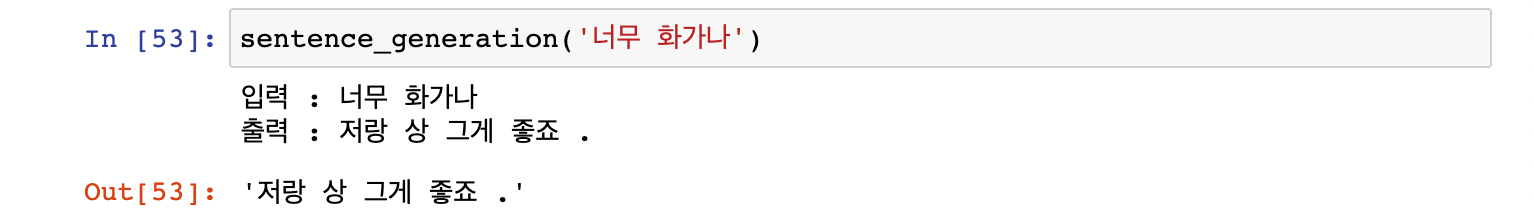

* 출력된 문장
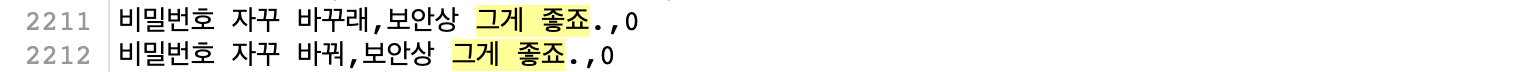

* 보안상 그게 좋죠 라는 답변 문장이 어떤 이유에선지 변형되어서 출력되었다. 기존 데이터와 비교했을 때도 어떤 관련이 있는지 상관관계를 찾기가 어렵다. 🥲

#### 공감능력이 제로인 챗봇
(1) 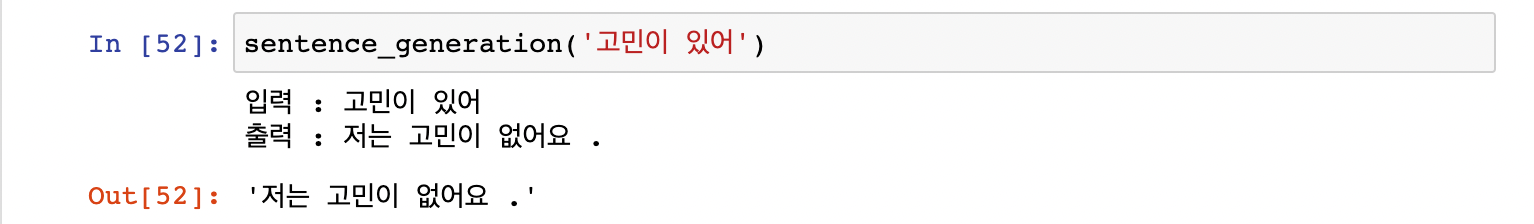

  * 제공된 데이터에서는 주어가 '너'를 가리키고 있었다. 하지만 이 입력문장에서의 생략된 주어는 '나'였다.
  
    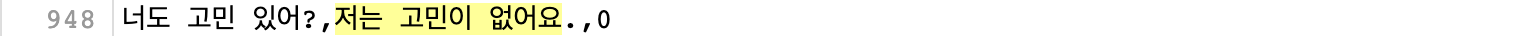
    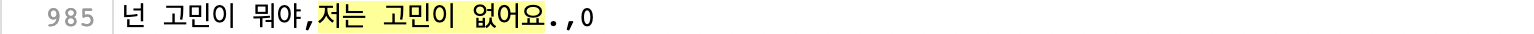

(2) 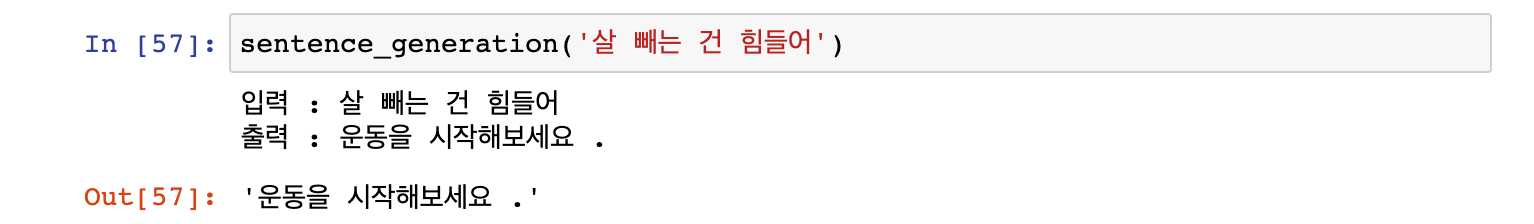


### 3-2. 이번 프로젝트에서 어려웠던 점
* 입력과 출력의 상관관계를 찾기가 어려웠습니다.
* 아직 정확한 구조에 대해 이해하지 못하고 있어서 더 많은 공부를 해야겠다고 생각합니다.



### 3-3. 프로젝트를 진행하면서 알아낸 점, 혹은 아직 모호한 점
* 챗봇 하나를 만들기 위해 정말 많은 데이터가 준비되어야한다는 것을 알게되었습니다.
* 더 멋진 챗봇을 만들기 위해서는 더 많은 데이터, 더 양질의 데이터가 준비되어야겠죠?
* 성능 개선을 위한 또 다른 방법은 무엇일지도 궁금합니다.


### 3-4. 루브릭 평가 지표를 맞추기 위해 시도한 것들
* Epoch수를 더 늘려보았습니다. 



### 3-5. 궁금한 사항
* 예상치 못한 질문을 들었을 때에도 자연스럽게 대답하도록 하는 방법이 궁금합니다.
* 띄어쓰기에 따라서 대답이 달라질 수 있기에 이런 점까지 보완할 수 있는 방법이 무엇인지 궁금합니다.



### 3-6. 참고사이트
* 데이터프레임 생성, CSV 파일 읽기/저장하기      
https://hleecaster.com/python-pandas-creating-and-loading-dataframes/
  
  
* 뉴스 요약봇 참고     
https://github.com/Sujin530/AIFFEL_project/blob/main/Exploration%2008/%5BE_08%5DNewsSummarization.ipynb


* 트랜스포머를 이용한 한국어 챗봇(Transformer Chatbot Tutorial)       
https://wikidocs.net/89786 


* 트랜스포머(Transformer)       
https://wikidocs.net/31379


